In [1]:
# Import dependencies
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statistics import stdev
from math import sqrt
from scipy.stats import norm
import pickle, warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# Read data

# All game scores historical through 2011
game_results_all = pd.read_csv('https://storage.googleapis.com/big-data-bowl/game-results-all.csv', encoding='latin')

# Offensive and defensive stats historical through 2011
season_stats_offense = pd.read_csv('https://storage.googleapis.com/big-data-bowl/season-stats-offense.csv', encoding='latin')
season_stats_defense = pd.read_csv('https://storage.googleapis.com/big-data-bowl/season-stats-defense.csv', encoding='latin')

# Kaggle games data
games = pd.read_csv('https://storage.googleapis.com/big-data-bowl/games.csv')

In [3]:
# Define team abbreviations
stats_team_abbr_dict = {
    'TB': 'Tampa Bay Buccaneers',
    'ATL': 'Atlanta Falcons',
    'BUF': 'Buffalo Bills',
    'CAR': 'Carolina Panthers',
    'CIN': 'Cincinnati Bengals',
    'DET': 'Detroit Lions',
    'HOU': 'Houston Texans',
    'IND': 'Indianapolis Colts',
    'TEN': 'Tennessee Titans',
    'WAS': 'Washington Redskins',
    'KC': 'Kansas City Chiefs',
    'NE': 'New England Patriots',
    'NO': 'New Orleans Saints',
    'NYG': 'New York Giants',
    'LA': 'Los Angeles Rams',
    'LV': 'Oakland Raiders',
    'CHI': 'Chicago Bears',
    'CLE': 'Cleveland Browns',
    'JAX': 'Jacksonville Jaguars',
    'MIA': 'Miami Dolphins',
    'NYJ': 'New York Jets',
    'PHI': 'Philadelphia Eagles',
    'PIT': 'Pittsburgh Steelers',
    'ARI': 'Arizona Cardinals',
    'LAC': 'Los Angeles Chargers',
    'SEA': 'Seattle Seahawks',
    'BAL': 'Baltimore Ravens',
    'GB': 'Green Bay Packers',
    'DEN': 'Denver Broncos',
    'MIN': 'Minnesota Vikings',
    'SF': 'San Francisco 49ers',
    'DAL': 'Dallas Cowboys'
}


In [4]:
# Merge offensive and defensive season stats
season_stats = season_stats_offense.merge(
    season_stats_defense,
    on='Team',
    suffixes=('_offensive', '_defensive')
)

# Create "Next Season" column for merging results data
season_stats['Next Season'] = season_stats['Season_offensive'] + 1
season_stats.drop(['Season_defensive', 'Season_offensive'], axis=1, inplace=True)
season_stats = season_stats.groupby(['Next Season', 'Team']).first().reset_index()

In [5]:
# Merge stats and scores for training data
training_data_all = game_results_all.merge(
    season_stats,
    left_on=['Home', 'Season'],
    right_on=['Team', 'Next Season']
)

training_data_all = training_data_all.merge(
    season_stats,
    left_on=['Visitor', 'Season'],
    right_on=['Team', 'Next Season'],
    suffixes=('_home', '_visitor')
)

training_data_all.drop(['Visitor', 'Home', 'Team_visitor', 'Team_home', 'Next Season_home', 'Next Season_visitor'], axis=1, inplace=True)

In [6]:
# Move 2021 data from training data to prediction data
training_data_raw = training_data_all.loc[training_data_all['Season'] < 2021]

In [7]:
# Clean home and visitor training sets for offense vs defense stats
home_training_data = training_data_raw[
    [c for c in training_data_raw.columns if \
     ('_offensive_home' in c) or \
     ('_defensive_visitor' in c) or \
     (c == 'Home Score')
    ]
]
home_training_data.loc[:, 'isHomeTeam'] = 1
home_training_data.drop([col for col in home_training_data.columns if ('_defensive_home' in col) or ('_offensive_visitor' in col)], inplace=True)
home_column_rename_dict = {col: col.replace('_home', '').replace('_visitor', '_opposing') for col in home_training_data.columns}
home_column_rename_dict['Home Score'] = 'Score'
home_training_data = home_training_data.rename(columns=home_column_rename_dict)

visitor_training_data = training_data_raw[
    [c for c in training_data_raw.columns if \
     ('_offensive_visitor' in c) or \
     ('_defensive_home' in c) or \
     (c == 'Visitor Score')
    ]
]
visitor_training_data.loc[:, 'isHomeTeam'] = 0
visitor_training_data.drop([col for col in visitor_training_data.columns if ('_offensive_home' in col) or ('_defensive_visitor' in col)], inplace=True)
visitor_column_rename_dict = {col: col.replace('_visitor', '').replace('_home', '_opposing') for col in visitor_training_data.columns}
visitor_column_rename_dict['Visitor Score'] = 'Score'
visitor_training_data = visitor_training_data.rename(columns=visitor_column_rename_dict)

In [8]:
# Combine home and visitor training sets
training_data = pd.concat([visitor_training_data, home_training_data], axis=0)

In [9]:
# Create home model
X = training_data.drop(['Score'], axis=1)
y = training_data['Score']

X_train, X_test, y_train, y_test = train_test_split(X, y)

model = LinearRegression()
model.fit(X_train, y_train)

score = model.score(X, y)
print(f"R2 Score: {score}")

R2 Score: 0.05371284220290762


In [74]:
X_test.columns

Index(['Gms_defensive_opposing', 'Tot Pts_defensive_opposing',
       'Pts/G_defensive_opposing', 'RushYds_defensive_opposing',
       'RYds/G_defensive_opposing', 'PassYds_defensive_opposing',
       'PYds/G_defensive_opposing', 'TotYds_defensive_opposing',
       'Yds/G_defensive_opposing', 'Gms_offensive', 'Tot Pts_offensive',
       'Pts/G_offensive', 'RushYds_offensive', 'RYds/G_offensive',
       'PassYds_offensive', 'PYds/G_offensive', 'TotYds_offensive',
       'Yds/G_offensive', 'isHomeTeam'],
      dtype='object')

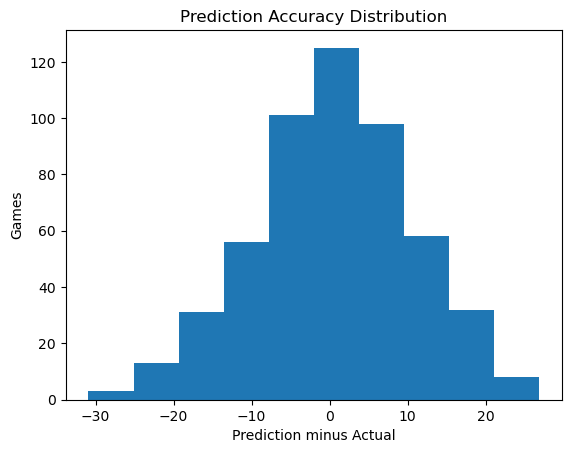

In [10]:
# Evaluate model accuracy
test_predictions = model.predict(X_test)
prediction_accuracy = test_predictions - y_test
plt.hist(prediction_accuracy)
plt.xlabel('Prediction minus Actual')
plt.ylabel('Games')
plt.title('Prediction Accuracy Distribution')
plt.show()

In [11]:
# Prepare 2021 prediction input
matchups = games.copy()
games['homeTeam'] = games['homeTeamAbbr'].apply(lambda x: stats_team_abbr_dict[x])
games['visitorTeam'] = games['visitorTeamAbbr'].apply(lambda x: stats_team_abbr_dict[x])

matchups = games[['gameId', 'homeTeam', 'visitorTeam']]
matchups['Season'] = 2021

In [12]:
prediction_data_raw = matchups.merge(
    season_stats,
    left_on=['homeTeam', 'Season'],
    right_on=['Team', 'Next Season']
)

prediction_data_raw = prediction_data_raw.merge(
    season_stats,
    left_on=['visitorTeam', 'Season'],
    right_on=['Team', 'Next Season'],
    suffixes=('_home', '_visitor')
)

prediction_data_raw.drop(['homeTeam', 'visitorTeam', 'Team_visitor', 'Team_home', 'Next Season_home', 'Next Season_visitor'], axis=1, inplace=True)

In [13]:
# Clean home and visitor prediction sets for offense vs defense stats
home_prediction_data = prediction_data_raw[
    [c for c in prediction_data_raw.columns if \
     ('_offensive_home' in c) or \
     ('_defensive_visitor' in c) or \
     (c == 'Home Score') or \
     (c == 'gameId') or \
     (c == 'gameId')
    ]
]
home_prediction_data.loc[:, 'isHomeTeam'] = 1
home_prediction_data.drop([col for col in home_prediction_data.columns if ('_defensive_home' in col) or ('_offensive_visitor' in col)], inplace=True)
home_prediction_data = home_prediction_data.rename(columns=home_column_rename_dict)

visitor_prediction_data = prediction_data_raw[
    [c for c in prediction_data_raw.columns if \
     ('_offensive_visitor' in c) or \
     ('_defensive_home' in c) or \
     (c == 'Visitor Score') or \
     (c == 'gameId')
    ]
]
visitor_prediction_data.loc[:, 'isHomeTeam'] = 0
visitor_prediction_data.drop([col for col in visitor_training_data.columns if ('_offensive_home' in col) or ('_defensive_visitor' in col)], inplace=True)
visitor_prediction_data = visitor_prediction_data.rename(columns=visitor_column_rename_dict)

In [14]:
# Combine home and visitor prediction sets
prediction_data = pd.concat([visitor_prediction_data, home_prediction_data], axis=0)

In [72]:
prediction_data

,gameId,Gms_defensive_opposing,Tot Pts_defensive_opposing,Pts/G_defensive_opposing,RushYds_defensive_opposing,RYds/G_defensive_opposing,PassYds_defensive_opposing,PYds/G_defensive_opposing,TotYds_defensive_opposing,Yds/G_defensive_opposing,Gms_offensive,Tot Pts_offensive,Pts/G_offensive,RushYds_offensive,RYds/G_offensive,PassYds_offensive,PYds/G_offensive,TotYds_offensive,Yds/G_offensive,isHomeTeam
0,2021090900,10,180,18.0,1166,116.6,1934,193.4,3100,310.0,16,395,24.7,1788,111.8,4161,260.1,5949,371.8,0
1,2021101710,9,166,18.4,1086,120.7,1839,204.3,2925,325.0,16,395,24.7,1788,111.8,4161,260.1,5949,371.8,0
2,2021091911,9,228,25.3,1321,146.8,1884,209.3,3205,356.1,16,395,24.7,1788,111.8,4161,260.1,5949,371.8,0
3,2021103112,9,191,21.2,1065,118.3,2366,262.9,3431,381.2,16,395,24.7,1788,111.8,4161,260.1,5949,371.8,0
4,2021091910,10,180,18.0,1166,116.6,1934,193.4,3100,310.0,16,396,24.8,1532,95.8,4363,272.7,5895,368.4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,2021101006,9,149,16.6,1044,116.0,1570,174.4,2614,290.4,16,416,26.0,1351,84.4,4003,250.2,5354,334.6,1
103,2021102406,9,264,29.3,1448,160.9,2298,255.3,3746,416.2,16,372,23.2,2018,126.1,4014,250.9,6032,377.0,1
104,2021100302,9,264,29.3,1448,160.9,2298,255.3,3746,416.2,16,372,23.2,1647,102.9,3655,228.4,5302,331.4,1
105,2021092000,9,264,29.3,1448,160.9,2298,255.3,3746,416.2,16,509,31.8,2118,132.4,4106,256.6,6224,389.0,1


In [15]:
# Make predictions
test_predictions = model.predict(prediction_data.drop(columns=['gameId'], axis=1))
predicted_data = prediction_data[['gameId', 'isHomeTeam']]
predicted_data['predictedScore'] = test_predictions

In [16]:
# Merge visitor scores to home scores
score_predictions = predicted_data[predicted_data['isHomeTeam'] == 1].merge(
    predicted_data[predicted_data['isHomeTeam'] == 0],
    on='gameId',
    suffixes=('_home', '_visitor')
)
score_predictions.drop(columns=['isHomeTeam_home', 'isHomeTeam_visitor'], inplace=True)

In [17]:
# Clean prediction results
score_predictions_teams = score_predictions.merge(games[['gameId', 'homeTeam', 'visitorTeam']])

prediction_results = score_predictions_teams.merge(
    game_results_all[['Home', 'Visitor', 'Home Score', 'Visitor Score']],
    left_on=['homeTeam', 'visitorTeam'],
    right_on=['Home', 'Visitor']
)

prediction_results.drop(columns=['homeTeam', 'visitorTeam'], inplace=True)
prediction_results['homeWin'] = prediction_results.apply(lambda row: int(row['Home Score'] > row['Visitor Score']), axis=1)
prediction_results['predictionCorrect'] = prediction_results.apply(lambda row: int(int(row['predictedScore_home'] > row['predictedScore_visitor']) == row['homeWin']), axis=1)
prediction_results['predictedScoreDiff'] = prediction_results.apply(lambda row: row['predictedScore_home'] - row['predictedScore_visitor'], axis=1)

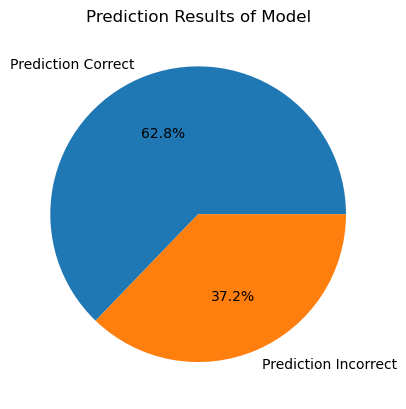

In [18]:
# Analyze prediction outcomes with pie chart
pie_data = [sum(prediction_results['predictionCorrect']), len(prediction_results['predictionCorrect']) - sum(prediction_results['predictionCorrect'])]
labels = ["Prediction Correct", "Prediction Incorrect"]
plt.pie(pie_data, labels=labels, autopct='%1.1f%%')
plt.title('Prediction Results of Model')
plt.show()

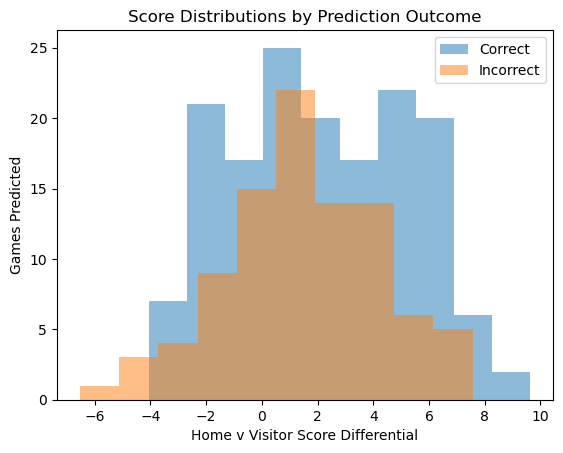

In [61]:
# Check distributions for correct vs incorrect predictions
correct_predictions = prediction_results[prediction_results['predictionCorrect'] == 1]
incorrect_predictions = prediction_results[prediction_results['predictionCorrect'] == 0]
plt.hist(
    correct_predictions['predictedScoreDiff'],
    alpha=0.5,
    bins=10
)
plt.hist(
    incorrect_predictions['predictedScoreDiff'],
    alpha=0.5,
    bins=10
)
plt.xlabel('Home v Visitor Score Differential')
plt.ylabel('Games Predicted')
plt.title('Score Distributions by Prediction Outcome')
plt.legend(['Correct', 'Incorrect'])
plt.show()

In [62]:
# stdev_correct = stdev(correct_predictions['predictedScoreDiff'])
# stdev_incorrect = stdev(incorrect_predictions['predictedScoreDiff'])
stdev_correct = 3.166981126573886
stdev_incorrect = 2.869264824251112

In [63]:
prediction_results['confidence'] = prediction_results.apply(
    lambda row: norm.pdf(row['predictedScoreDiff'],0,stdev_correct)/(norm.pdf(row['predictedScoreDiff'],0,stdev_correct)+norm.pdf(row['predictedScoreDiff'],0,stdev_incorrect)),
    axis=1
)

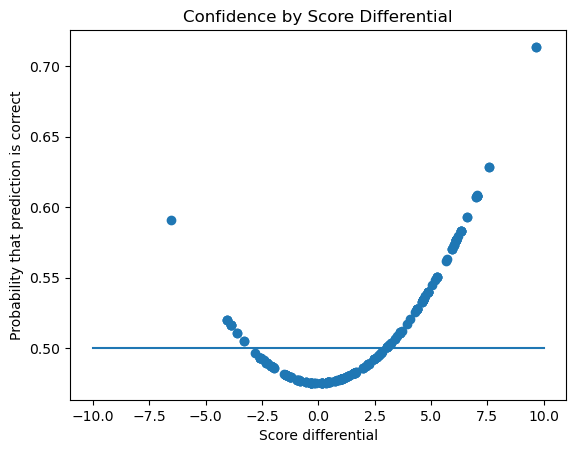

In [67]:
plt.scatter(
    prediction_results['predictedScoreDiff'],
    prediction_results['confidence']
)
plt.plot(
    [-10, 10],
    [0.5, 0.5]
)
plt.xlabel('Score differential')
plt.ylabel('Estimated confidence that prediction is correct')
plt.title('Confidence by Score Differential')
plt.show()

In [71]:
# pickle.dump(model,open('win-prediction-linear.pkl','wb'))